<a href="https://colab.research.google.com/github/mxn170019/Pneumonia-detection-using-X-ray-images/blob/master/Kaggle-Xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
path = Path('/Users/mandeep/abc/chest_xray')
path_train = Path('/Users/mandeep/abc/chest_xray/train')
path_val = Path('/Users/mandeep/abc/chest_xray/valid')
path_test = Path('/Users/mandeep/abc/chest_xray/test')
pathlist = ['train','valid','test']

In [0]:
classes = ['PNEUMONIA','NORMAL']

In [0]:
for i in pathlist:
    for c in classes:
        print(i +" - " + c)
        verify_images(path/i/c, delete=True, max_size=500)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=24).normalize(imagenet_stats)


In [0]:
# np.random.seed(42)
# data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['NORMAL', 'PNEUMONIA']

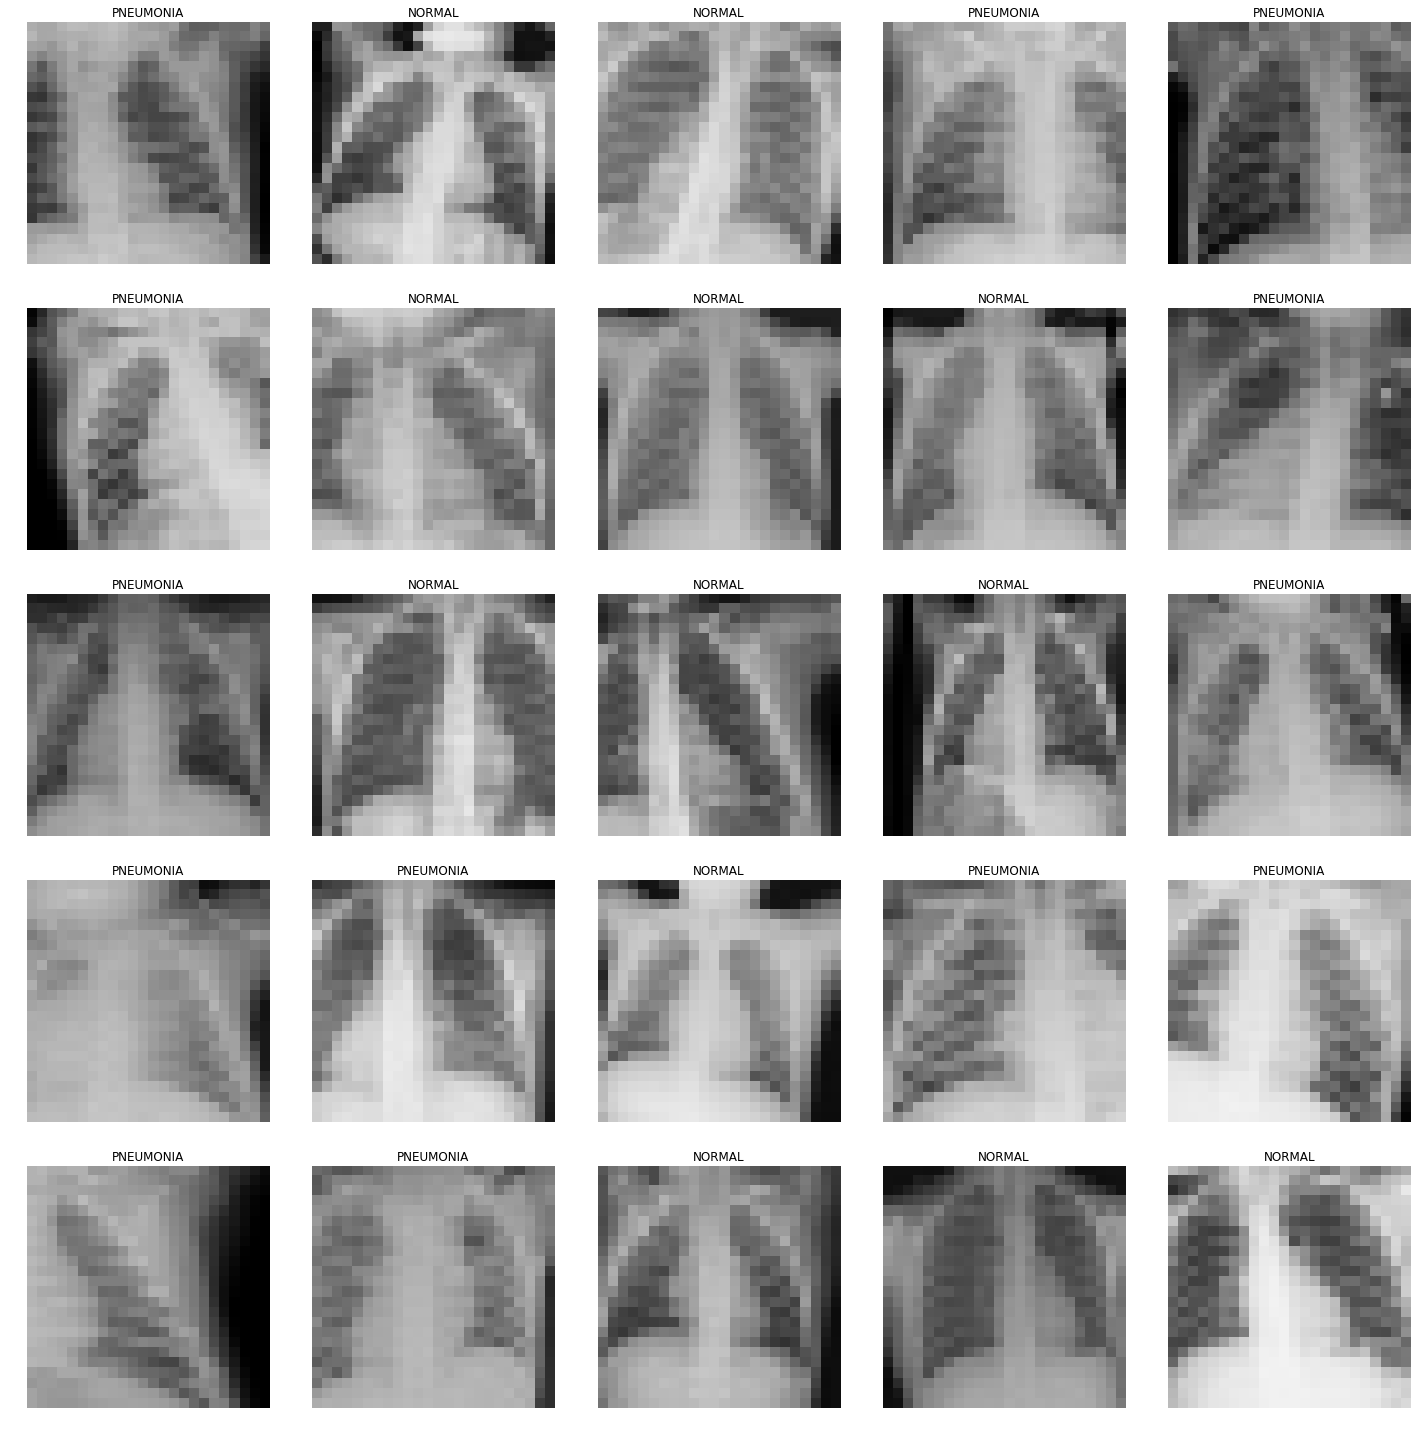

In [0]:
data.show_batch()

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

# Train Model

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

In [0]:
learn.save('stage-1')

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Required Libraries


In [0]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from pathlib import Path
import seaborn as sns
from skimage.io import imread

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import time


np.random.seed(111)


# Data Directory

In [0]:
# Define path to the data directory
data_dir = Path('/content/drive/My Drive/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

# Reading Train test and Val data files

## Training set

In [111]:
# Get the path to the normal and pneumonia sub-directories
train_normal_dir = train_dir / 'NORMAL'
train_pneumonia_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
train_normal_imgs = train_normal_dir.glob('*.jpeg')
train_pneumonia_imgs = train_pneumonia_dir.glob('*.jpeg')

#Generating the train data
train_data = []

#adding normal images to train data
for img in train_normal_imgs:
  train_data.append((img,0))

#adding pneumonia images to train data
for img in train_pneumonia_imgs:
  train_data.append((img,1))

#convering train list to data frame and visualize
train_df = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_df = train_df.sample(frac=1.).reset_index(drop=True)


display(train_df.head(5))
print(train_df.shape)
print(" ")
train_df['label'].value_counts()

,image,label
0,/content/drive/My Drive/chest_xray/train/PNEUM...,1
1,/content/drive/My Drive/chest_xray/train/NORMA...,0
2,/content/drive/My Drive/chest_xray/train/PNEUM...,1
3,/content/drive/My Drive/chest_xray/train/PNEUM...,1
4,/content/drive/My Drive/chest_xray/train/PNEUM...,1


(5208, 2)
 


1    3867
0    1341
Name: label, dtype: int64

## Testing Set

In [112]:
# Get the path to the normal and pneumonia sub-directories
test_normal_dir = test_dir / 'NORMAL'
test_pneumonia_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_imgs = test_normal_dir.glob('*.jpeg')
test_pneumonia_imgs = test_pneumonia_dir.glob('*.jpeg')

#Generating the train data
test_data = []

#adding normal images to train data
for img in test_normal_imgs:
  test_data.append((img,0))

#adding pneumonia images to train data
for img in test_pneumonia_imgs:
  test_data.append((img,1))

#convering train list to data frame and visualize
test_df = pd.DataFrame(test_data, columns=['image', 'label'],index=None)
test_df = test_df.sample(frac=1.).reset_index(drop=True)


display(test_df.head(5))
print(test_df.shape)
print(" ")
test_df['label'].value_counts()

,image,label
0,/content/drive/My Drive/chest_xray/test/NORMAL...,0
1,/content/drive/My Drive/chest_xray/test/PNEUMO...,1
2,/content/drive/My Drive/chest_xray/test/PNEUMO...,1
3,/content/drive/My Drive/chest_xray/test/NORMAL...,0
4,/content/drive/My Drive/chest_xray/test/PNEUMO...,1


(624, 2)
 


1    390
0    234
Name: label, dtype: int64

## Validation Set

In [113]:
# Get the path to the normal and pneumonia sub-directories
val_normal_dir = val_dir / 'NORMAL'
val_pneumonia_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
val_normal_imgs = val_normal_dir.glob('*.jpeg')
val_pneumonia_imgs = val_normal_dir.glob('*.jpeg')

#Generating the train data
val_data = []

#adding normal images to train data
for img in val_normal_imgs:
  val_data.append((img,0))

#adding pneumonia images to train data
for img in val_pneumonia_imgs:
  val_data.append((img,1))

#convering train list to data frame and visualize
val_df = pd.DataFrame(val_data, columns=['image', 'label'],index=None)
val_df = val_df.sample(frac=1.).reset_index(drop=True)


display(val_df.head(5))
print(val_df.shape)
print(" ")
val_df['label'].value_counts()

,image,label
0,/content/drive/My Drive/chest_xray/val/NORMAL/...,1
1,/content/drive/My Drive/chest_xray/val/NORMAL/...,1
2,/content/drive/My Drive/chest_xray/val/NORMAL/...,0
3,/content/drive/My Drive/chest_xray/val/NORMAL/...,0
4,/content/drive/My Drive/chest_xray/val/NORMAL/...,1


(16, 2)
 


1    8
0    8
Name: label, dtype: int64

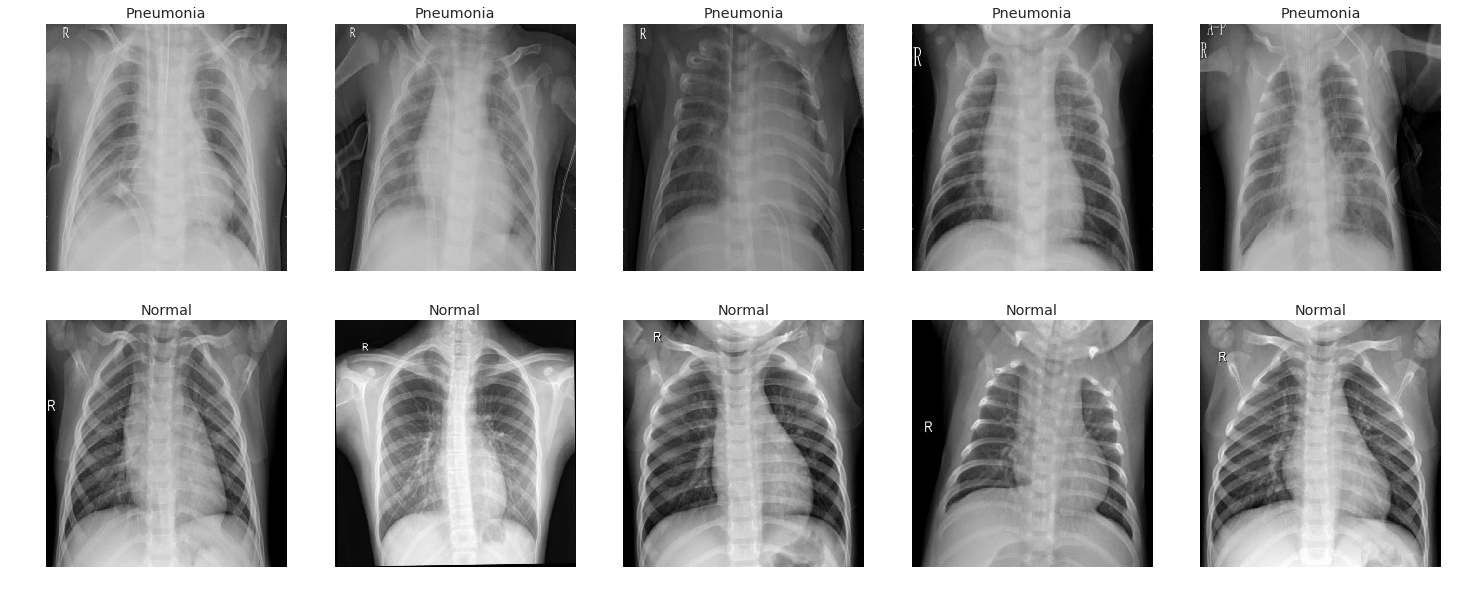

In [117]:
# Get few samples for both the classes
pneumonia_samples = (train_df[train_df['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(25,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()